In [108]:
import numpy as np 
import pandas as pd 

import warnings
warnings.filterwarnings("ignore")

import math
from itertools import accumulate
from scipy.stats import skew, kurtosis

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [109]:
def apply_transformation(timeseries,transformation):

    """
        Description: 

        :param timeseries: The timeseries
        :param transformation: The transformation to apply to the data
    """

    transformed_timeseries = None

    if transformation == 'log_diff':
        transformed_timeseries = 100*(np.exp(np.log(timeseries).diff(1)) - 1)

    if transformation == 'first_diff':
        transformed_timeseries = timeseries.diff(1)

    return transformed_timeseries

In [110]:

def log_difference(forecast_horizon, historical_series, forecast_order, product, moving_average):

    """
    
        Description: 

        :param forecast_horizon:
        :param historical_series:
        :param forecast_order:
        :param product: 
    
    """

    all_forecasts = []

    model_metadata = {

        "model_id":[],
        "aic":[],
        "order":[],
        "mae":[],
        "mse":[],
        "skew":[],
        "kurtosis":[]

    }

    # Read in the data
    ts_df = pd.read_csv(rf'C:\Users\james\OneDrive\Documents\GitHub\jamsydLibrary\approved_projects\interactive_brokers\Data\BATS_{product}, 1D.csv',index_col='time',parse_dates=True)

    # Perform initial transformations
    ts_df['transformation'] = apply_transformation(timeseries = ts_df['close'], transformation = "log_diff")
    ts_df['ma']             = ts_df['close'].rolling(window=moving_average).mean()
    ts_df['ma_diff']        = ts_df['ma'].diff(1)
    ts_df['pnl']            = ts_df['close'].diff(1)
    ts_df                   = ts_df.dropna(axis=0)

    # Assuming ts_df is already defined and has a DateTime index
    ts_df.index = pd.to_datetime(ts_df.index)

    # Infer the frequency of the DateTime index
    inferred_freq = pd.infer_freq(ts_df.index)
    if inferred_freq:
        ts_df = ts_df.asfreq(inferred_freq)

    i = 0
    while i < len(ts_df):

        # Ensure there are enough observations for historical_series
        if i + historical_series >= len(ts_df):
            break

        end = min(i + forecast_horizon, len(ts_df))

        # Corrected the slicing of the DataFrame
        mod = sm.tsa.arima.ARIMA(ts_df['transformation'].iloc[i:i + historical_series], order=forecast_order)
        res = mod.fit()

        # Forecast the next 5 days
        forecast = res.forecast(steps=forecast_horizon)

        # Taking previous day
        last_close        = ts_df['close'].iloc[i + historical_series - 1]
        forecasts         = ((1 + forecast / 100) * last_close).tolist()
        forecast_dates    = ts_df.index[i + historical_series:i + historical_series + forecast_horizon].tolist()
        close_actual      = ts_df['close'].iloc[i + historical_series:i + historical_series + forecast_horizon].tolist()
        model_id          = product + '_' + str(i) + "_" + str(forecast_order)

        # store model metadata
        model_metadata['model_id'].append(model_id)
        model_metadata['aic'].append(res.aic)
        model_metadata['order'].append(str(forecast_order))
        model_metadata['mae'].append(np.mean(np.abs(res.resid)))
        model_metadata['mse'].append(np.mean(np.square(res.resid)))
        model_metadata['skew'].append(skew(res.resid))
        model_metadata['kurtosis'].append(kurtosis(res.resid))

        # Information to store in list
        forecast_position = [i for i in range(1,forecast_horizon + 1)]
        model_id_lst      = forecast_horizon*[model_id]
        last_price        = forecast_horizon*[last_close]
        std_dev           = forecast_horizon*[np.std(ts_df['close'].iloc[i:i + historical_series].diff(1))]
        mean              = forecast_horizon*[np.mean(ts_df['close'].iloc[i:i + historical_series].diff(1))]
        ma_diff           = forecast_horizon*[ts_df['ma_diff'].iloc[i + historical_series - 1]]

        # Append the forecasts and corresponding dates to all_forecasts
        all_forecasts.extend(list(zip(forecast_dates, forecasts, close_actual, forecast_position, model_id_lst, last_price, std_dev, mean, ma_diff)))
        i += forecast_horizon 

        if i > 100:
            break

    # Saving the forecast dataframe
    forecast_df          = pd.DataFrame(all_forecasts, columns=['Date', 'Forecast', 'Close', 'Forecast_Position', 'model_id','last_price', 'standard_dev', 'mean','ma_diff'])
    forecast_df['error'] = forecast_df['Close'] - forecast_df['Forecast']

    # Store model metadata
    pd.DataFrame(model_metadata).to_csv(rf'model_metadata_log_first_diff_{product}_{forecast_order}_{historical_series}_{forecast_horizon}.csv')
    
    return forecast_df

In [111]:
df = pd.read_csv(r'C:\Users\james\OneDrive\Documents\GitHub\jamsydLibrary\test.csv')

In [112]:
import matplotlib.pyplot as plt

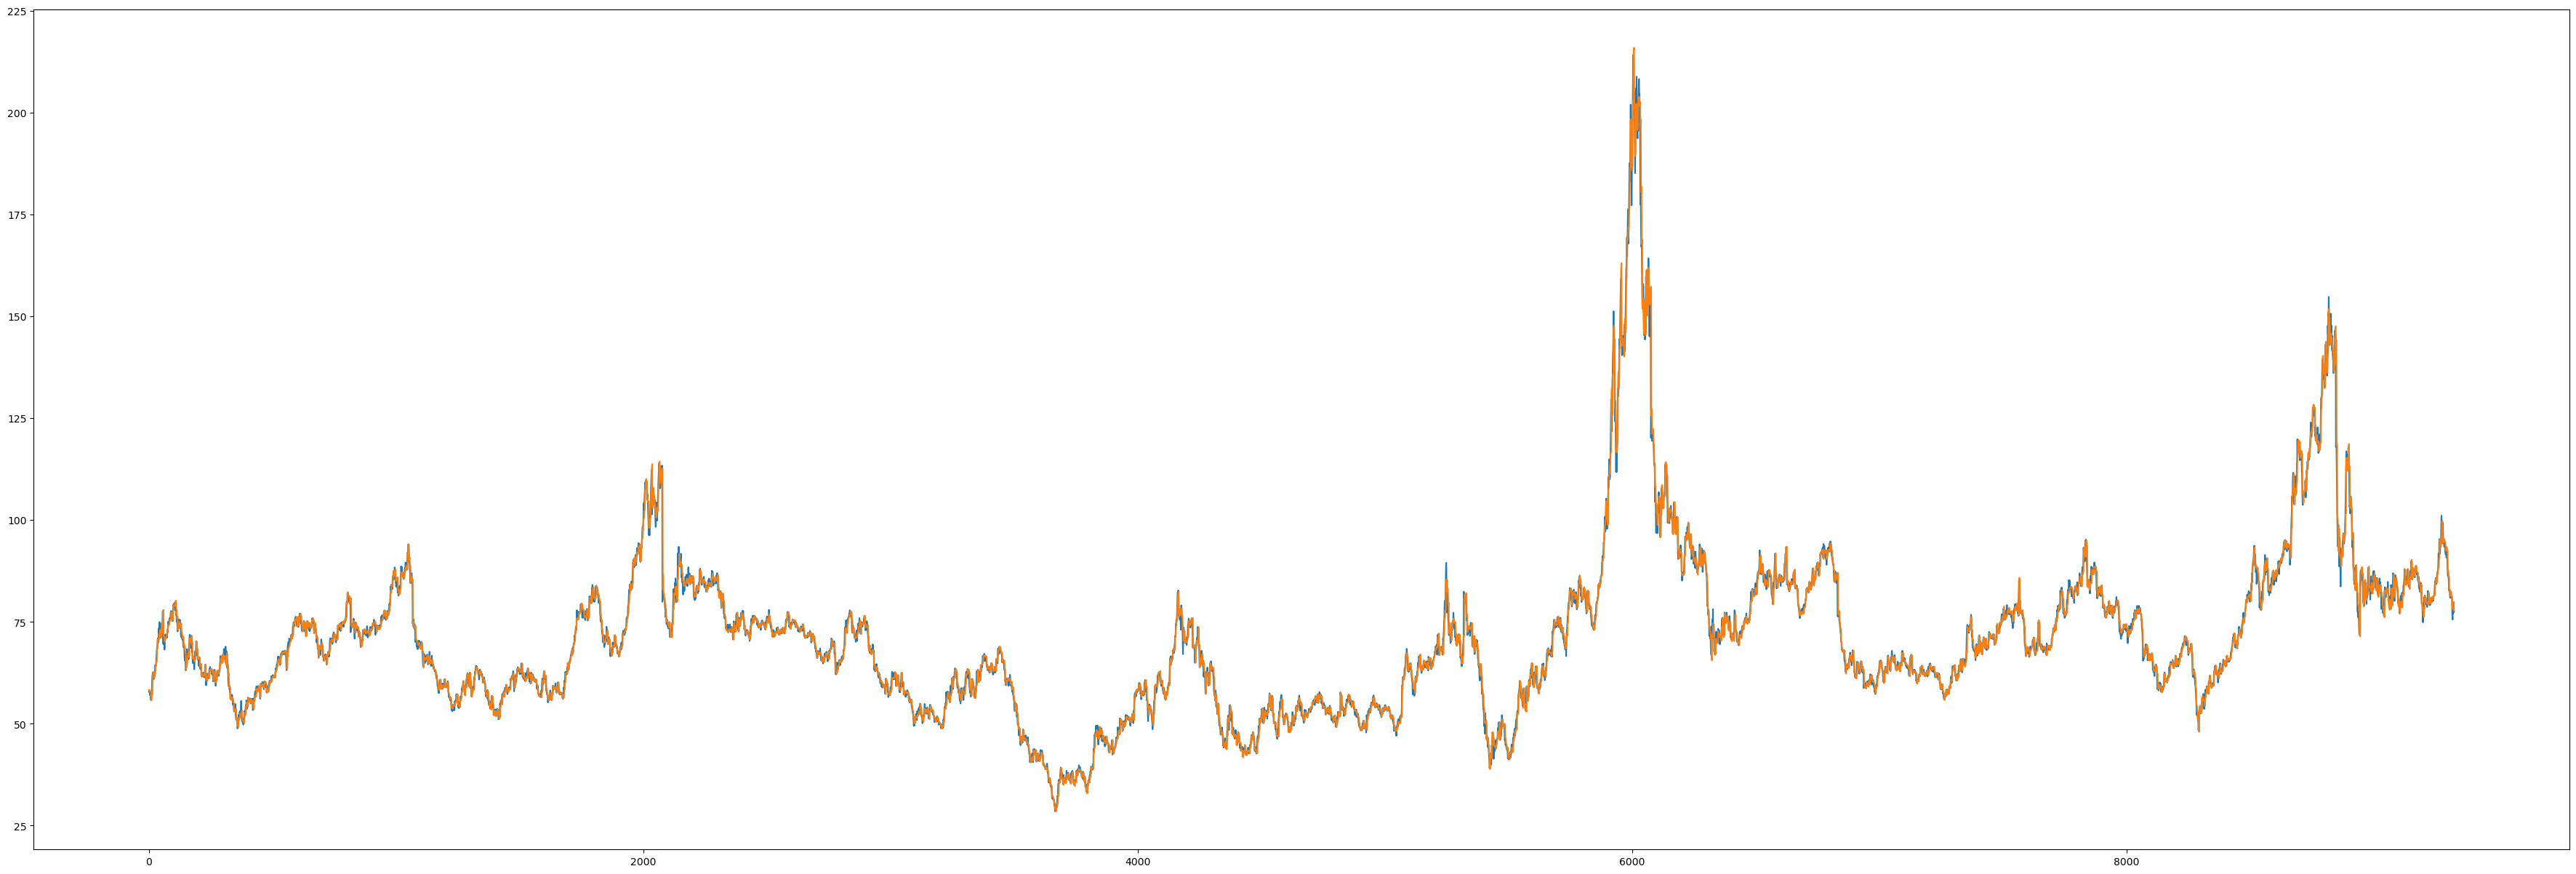

In [113]:
plt.figure(figsize=(45,15))
plt.plot(df['Close'])
plt.plot(df['Forecast'])


In [114]:
df

,Unnamed: 0,Date,Forecast,Close,Forecast_Position,model_id,last_price,standard_dev,mean,ma_diff,pnl,error
0,0,1987-03-25,58.299208,57.85,1,"EWA_0_(3, 0, 0)",58.32,2.150950,-0.014314,0.226111,-0.47,-0.449208
1,1,1987-03-26,58.290058,57.82,2,"EWA_0_(3, 0, 0)",58.32,2.150950,-0.014314,0.226111,-0.03,-0.470058
2,2,1987-03-27,58.278195,57.95,3,"EWA_0_(3, 0, 0)",58.32,2.150950,-0.014314,0.226111,0.13,-0.328195
3,3,1987-03-30,57.933019,57.45,1,"EWA_3_(3, 0, 0)",57.95,2.151057,-0.016221,0.173333,-0.50,-0.483019
4,4,1987-03-31,57.914070,57.05,2,"EWA_3_(3, 0, 0)",57.95,2.151057,-0.016221,0.173333,-0.40,-0.864070
...,...,...,...,...,...,...,...,...,...,...,...,...
9321,9321,2024-05-06,78.138263,77.04,1,"EWA_9321_(3, 0, 0)",77.92,1.327094,-0.023344,-0.455000,-0.88,-1.098263
9322,9322,2024-05-07,77.780524,77.39,2,"EWA_9321_(3, 0, 0)",77.92,1.327094,-0.023344,-0.455000,0.35,-0.390524
9323,9323,2024-05-08,77.719980,79.86,3,"EWA_9321_(3, 0, 0)",77.92,1.327094,-0.023344,-0.455000,2.47,2.140020
9324,9324,2024-05-09,79.890841,78.38,1,"EWA_9324_(3, 0, 0)",79.86,1.331859,-0.019398,-0.154444,-1.48,-1.510841


In [115]:
forecast_df = df 

In [116]:
forecast_df = forecast_df.dropna(axis=0)

In [117]:
df.head()

,Unnamed: 0,Date,Forecast,Close,Forecast_Position,model_id,last_price,standard_dev,mean,ma_diff,pnl,error
0,0,1987-03-25,58.299208,57.85,1,"EWA_0_(3, 0, 0)",58.32,2.150950,-0.014314,0.226111,-0.47,-0.449208
1,1,1987-03-26,58.290058,57.82,2,"EWA_0_(3, 0, 0)",58.32,2.150950,-0.014314,0.226111,-0.03,-0.470058
2,2,1987-03-27,58.278195,57.95,3,"EWA_0_(3, 0, 0)",58.32,2.150950,-0.014314,0.226111,0.13,-0.328195
3,3,1987-03-30,57.933019,57.45,1,"EWA_3_(3, 0, 0)",57.95,2.151057,-0.016221,0.173333,-0.50,-0.483019
4,4,1987-03-31,57.914070,57.05,2,"EWA_3_(3, 0, 0)",57.95,2.151057,-0.016221,0.173333,-0.40,-0.864070


In [118]:
import math
from itertools import accumulate

pnl = []

for model_id in forecast_df['model_id'].unique():

    forecast_move     = forecast_df[forecast_df['model_id'] == model_id]['Forecast'].iloc[-1] - forecast_df[forecast_df['model_id'] == model_id]['last_price'].iloc[0]
    forecast_move_std = forecast_df[forecast_df['model_id'] == model_id]['standard_dev'].iloc[0]
    

    # if forecast_move < 0: #-1*forecast_df[forecast_df['model_id'] == model_id]['standard_dev'].iloc[-1]:
    #     # if forecast_df[forecast_df['model_id'] == model_id]['ma_diff'].iloc[-1] < 0:
    #     pnl.extend(-1*forecast_df[forecast_df['model_id'] == model_id]['pnl'].to_list())

    if forecast_move > 0:# 1*forecast_df[forecast_df['model_id'] == model_id]['standard_dev'].iloc[-1]:
        # if forecast_df[forecast_df['model_id'] == model_id]['ma_diff'].iloc[-1] > 0:
        pnl.extend(forecast_df[forecast_df['model_id'] == model_id]['pnl'].to_list())

# Replace NaN values with zero
pnl    = [0 if math.isnan(x) else x for x in pnl]
vector = list(accumulate(pnl))

In [119]:
vector

[-0.0500000000000042,
 0.34999999999999437,
 0.6999999999999957,
 -0.4999999999999998,
 -0.9900000000000018,
 -0.6000000000000012,
 0.2999999999999903,
 1.7699999999999891,
 2.6499999999999986,
 2.54999999999999,
 3.3800000000000026,
 4.919999999999995,
 5.1599999999999895,
 4.019999999999989,
 4.6399999999999935,
 5.649999999999999,
 7.649999999999999,
 6.219999999999992,
 7.380000000000003,
 9.149999999999999,
 7.149999999999999,
 7.399999999999999,
 6.04999999999999,
 5.29999999999999,
 6.149999999999999,
 8.149999999999999,
 8.699999999999996,
 6.859999999999992,
 6.899999999999999,
 6.600000000000001,
 8.350000000000001,
 10.329999999999991,
 11.949999999999996,
 5.189999999999991,
 3.79999999999999,
 5.469999999999992,
 5.329999999999991,
 3.5700000000000003,
 4.249999999999993,
 2.3699999999999974,
 3.8800000000000026,
 5.04999999999999,
 5.709999999999987,
 5.559999999999981,
 5.9499999999999815,
 5.79999999999999,
 4.9699999999999775,
 6.9699999999999775,
 6.249999999999979,
 

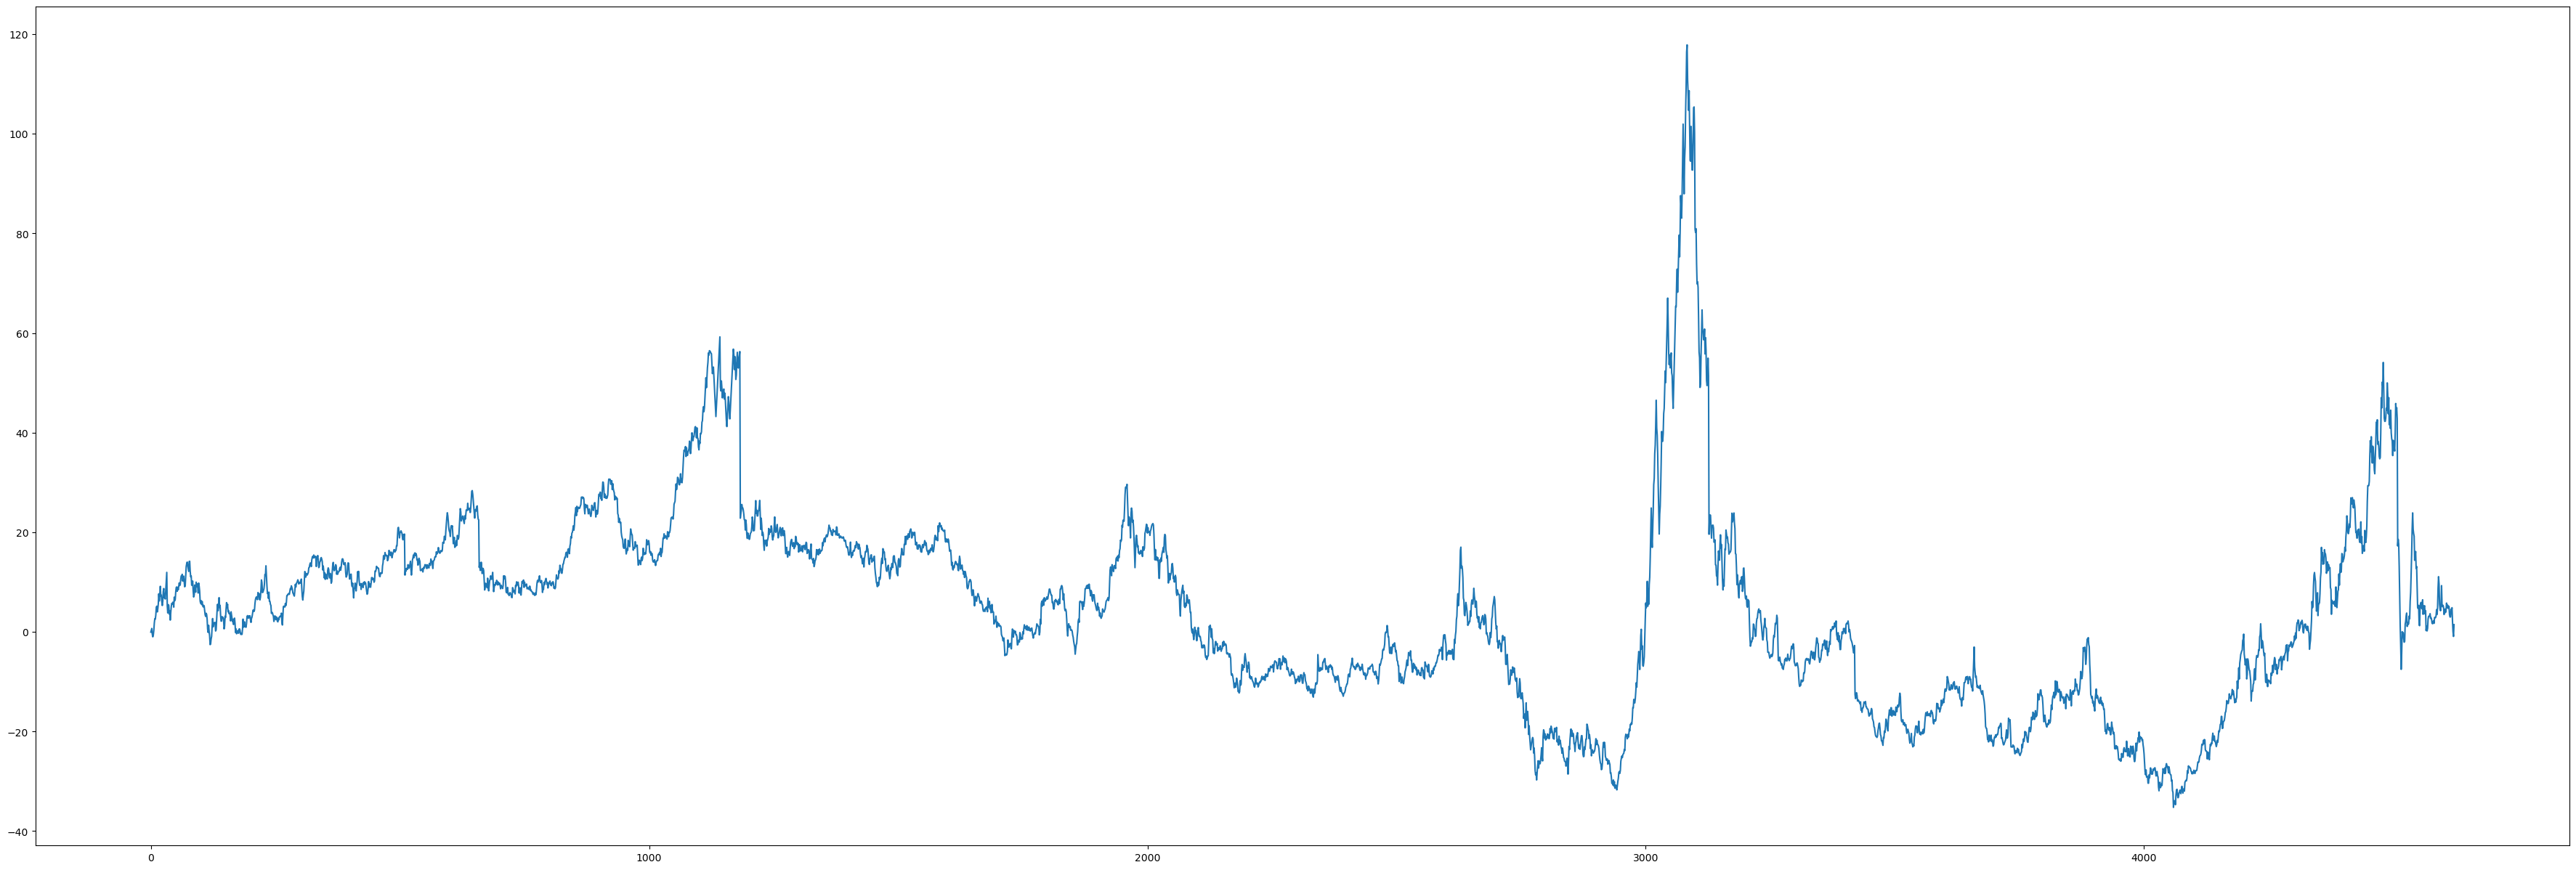

In [120]:
plt.figure(figsize=(45,15))
plt.plot(vector)
plt.show()